# Facebook Prophet application to a time series problem

**Notebook made by: André Reis & Gonçalo Freitas, University of Aveiro ©**

References : 

https://mkang32.github.io/python/2020/12/15/prophet-intro.html#train

https://facebook.github.io/prophet/docs/diagnostics.html

In [1]:
import numpy as np
np.random.seed(7)  # for reproducibility
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from datetime import datetime
import sys
from matplotlib import pyplot
from keras.layers import Bidirectional

#from read_files import read_files

import matplotlib.pyplot as plt
p = 1

# Setup variables

In [2]:
if p == 1:
    path = "D:/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
if p == 0:
    path = "C:/Users/OMEN/OneDrive - Universidade de Aveiro/Mestrado/4 ano/1 semestre/AIA/Modulo 2/Projeto/time_series/"
product_group_id = 958
time_series_folder = 1 #1,2,3

product_information = pd.read_pickle(path+"Data/product_information")
print(product_information.loc[product_group_id])

empresa = "Ripley"    # company we gonna study

product       huawei Y9S 128GB
offer_type            unlocked
Name: 958, dtype: object


# Get data

In [3]:
df_long = pd.read_pickle(path+"Data/time_series_"+str(time_series_folder)+"/long_product_group_id_" + str(product_group_id))
df_wide = df_long.reset_index().groupby(['timestamp', "company"])["price"].first().unstack().reset_index().set_index("timestamp")

# Fill missing timestamps
timestamps  = pd.DataFrame(index = pd.date_range(df_wide.index[0],df_wide.index[-1], freq='D'))
df_wide = pd.merge(timestamps, df_wide, left_index = True, right_index = True, how = 'left')
df_wide.columns.name = None

**Data Overview**

<Figure size 640x480 with 0 Axes>

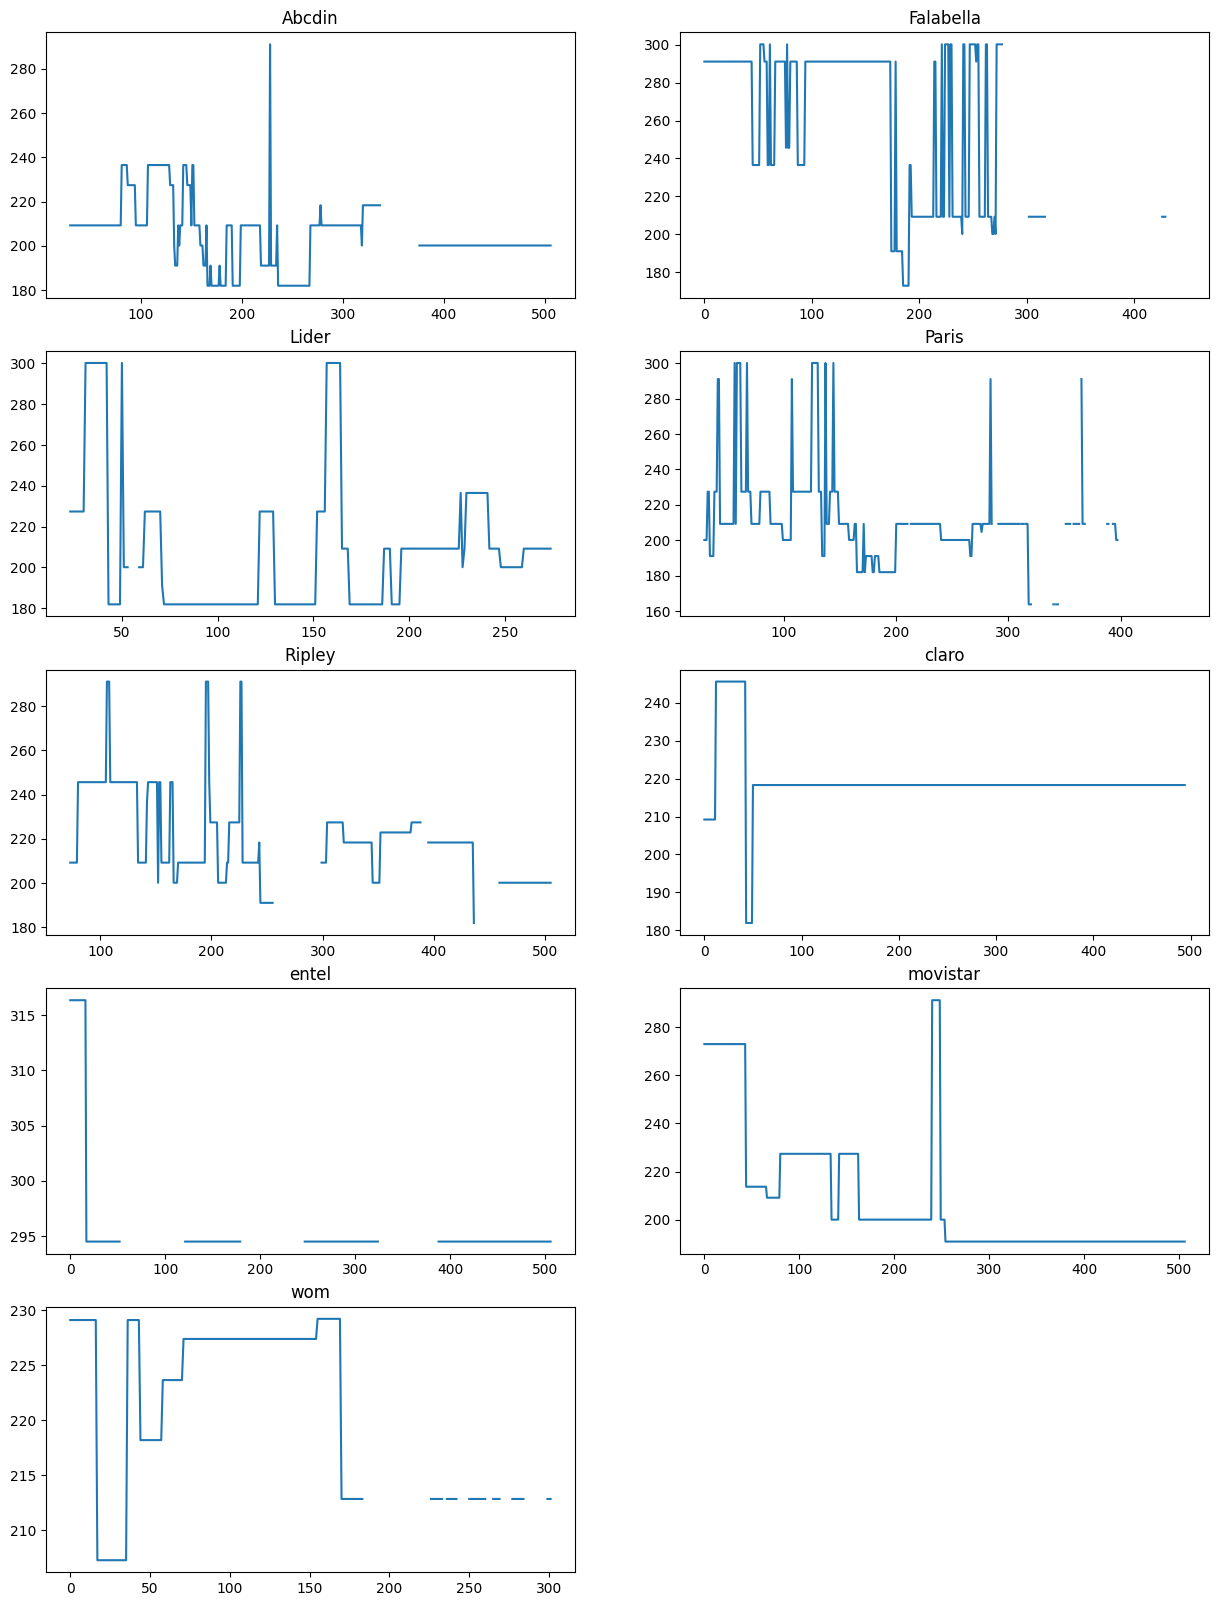

In [4]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,20))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

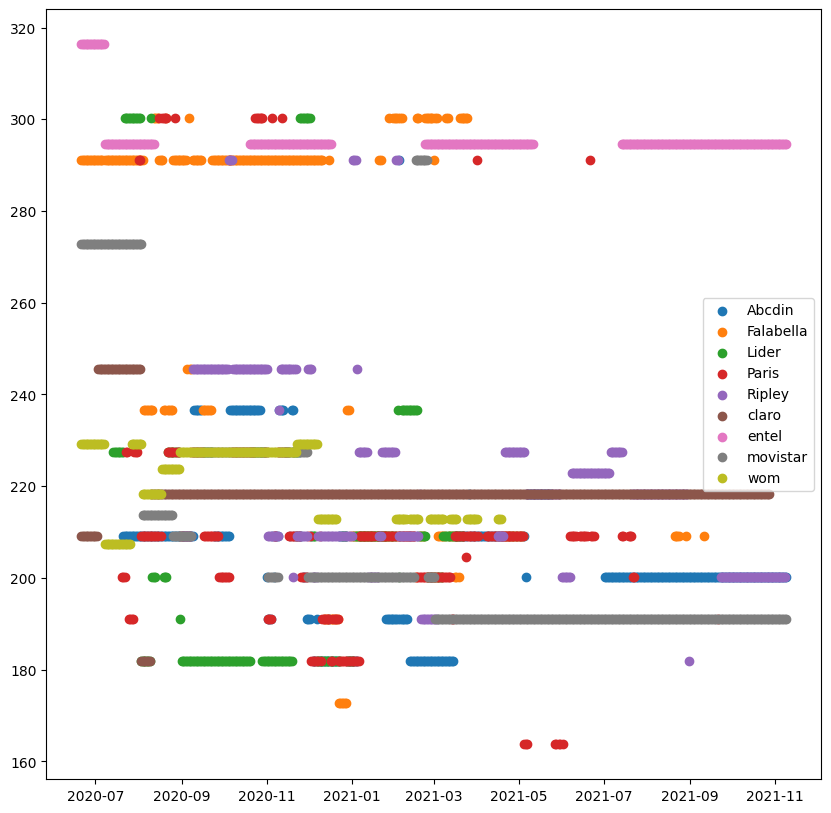

In [5]:
plt.figure(figsize=(10, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)

plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

**Interpolate to fix the NaN values and substitute them with a estimation of the value in that time**

In [6]:
"""
df_wide = df_wide.fillna(df_wide.mean())
"""
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")
print(df_wide)

                Abcdin   Falabella       Lider       Paris      Ripley  \
2020-06-21  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-22  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-23  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-24  209.214955  291.085236  227.408351  200.118257  209.214955   
2020-06-25  209.214955  291.085236  227.408351  200.118257  209.214955   
...                ...         ...         ...         ...         ...   
2021-11-05  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-06  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-07  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-08  200.118257  209.214955  209.214955  191.021559  200.118257   
2021-11-09  200.118257  209.214955  209.214955  191.021559  200.118257   

                 claro       entel    movistar         wom  
2020-06-21  209.214955  316.346766  272.891840  22

**Data overview after interpolation**

<Figure size 640x480 with 0 Axes>

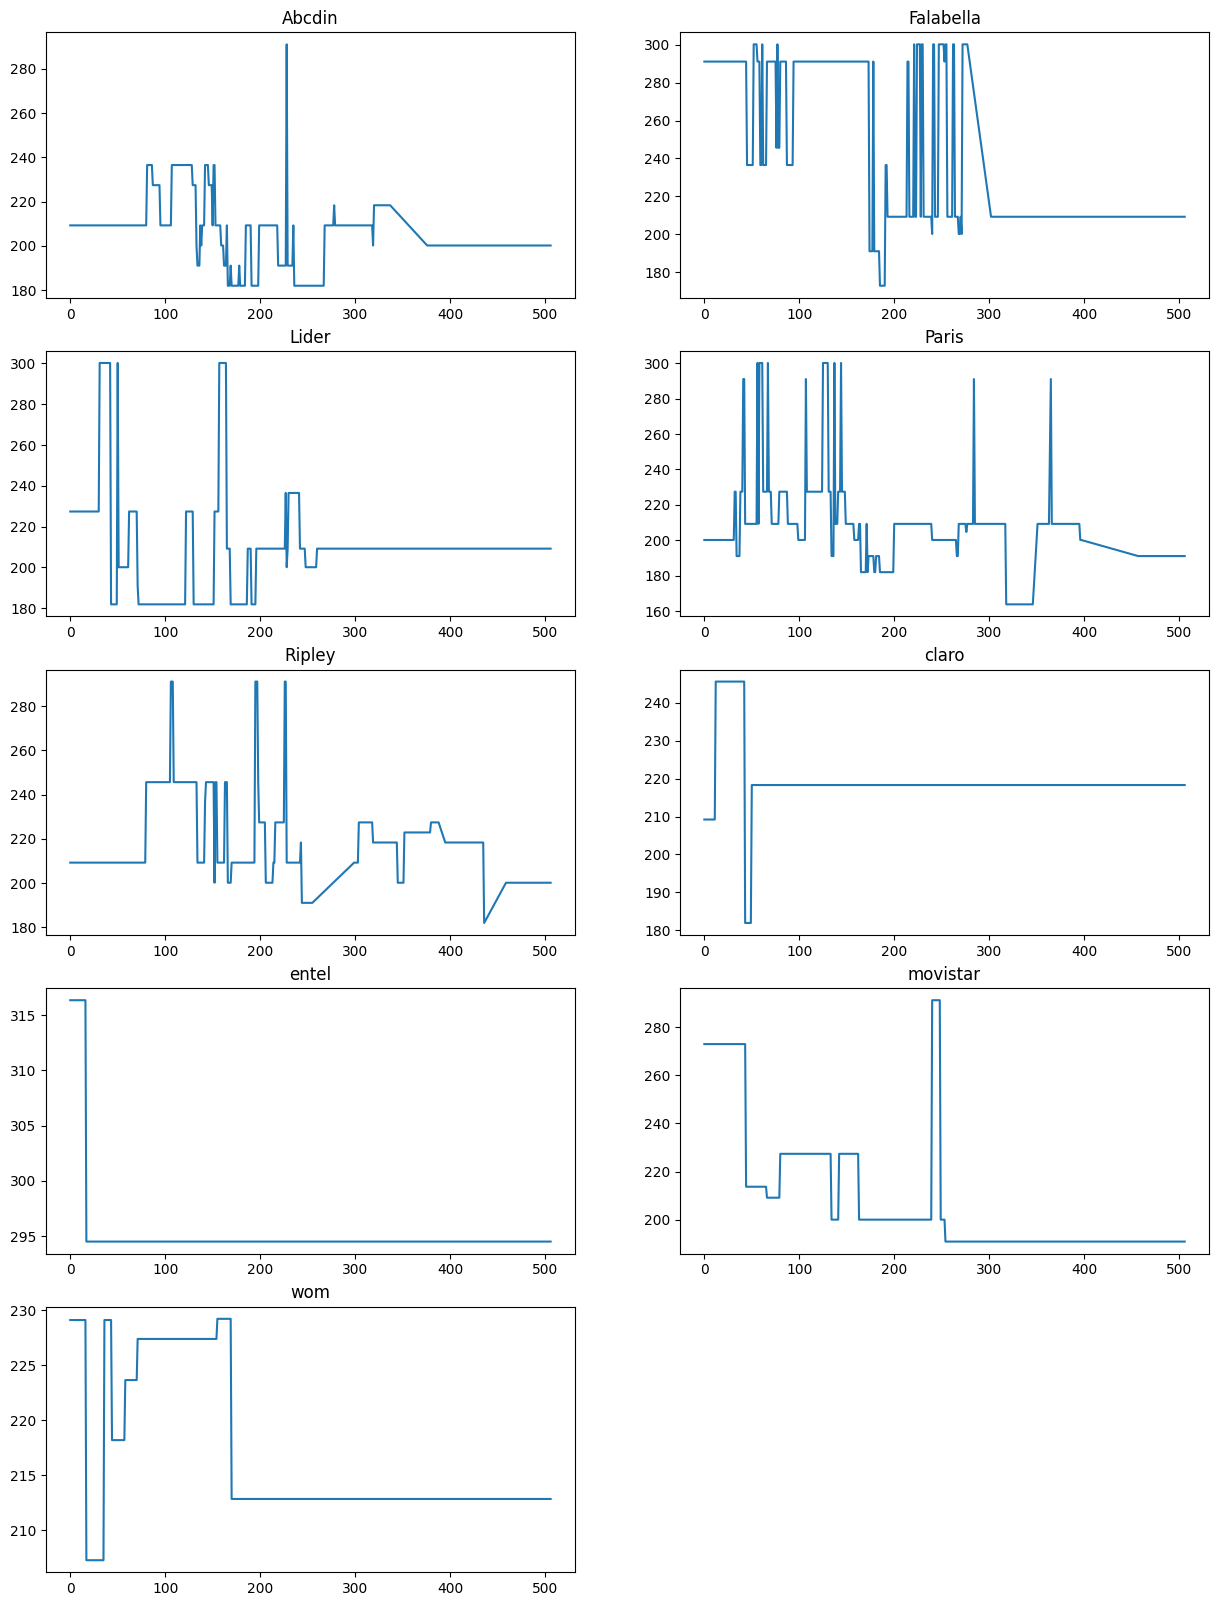

In [7]:
df_wide.columns
values = df_wide.values

# plot each column
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8]
i = 1
plt.figure()
f = plt.figure(figsize=(15,20))
for col in columns:
    plt.subplot(5, 2, i)
    plt.plot(values[:, col])
    plt.title(df_wide.columns[col])
    i += 1
plt.show()

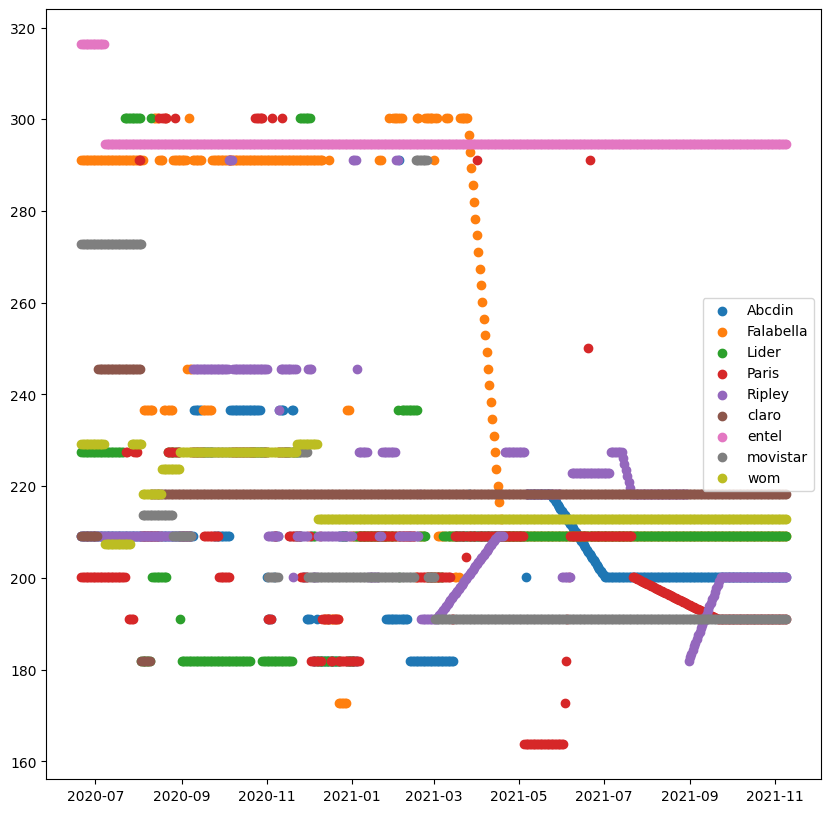

In [8]:
plt.figure(figsize=(10, 10))
for name in df_wide.columns:
    plt.scatter(df_wide.index, df_wide[name])
plt.legend(df_wide.columns)

plt.savefig(path+"product_"+str(product_group_id)+".png",dpi=600,format="png")

#  Facebook Prophet

Install prophet module (uncomment if not yet installed)

In [9]:
#pip install prophet

In [10]:
import pandas as pd
from prophet import Prophet

d:\Anaconda\envs\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [11]:
raw_seq = df_wide[empresa]


percent_train = 0.6
value = int(len(raw_seq)*percent_train)
train = {"ds":df_wide.index.tolist()[:value],"y":raw_seq[:value]}
test = {"ds":df_wide.index.tolist()[value:],"y":raw_seq[value:]}
train = pd.DataFrame(train)
test = pd.DataFrame(test)

X_train = raw_seq[:value]
X_test = raw_seq[value:]

#print train and test shape
print(train.shape)
print(test.shape)

(304, 2)
(203, 2)


<Figure size 640x480 with 0 Axes>

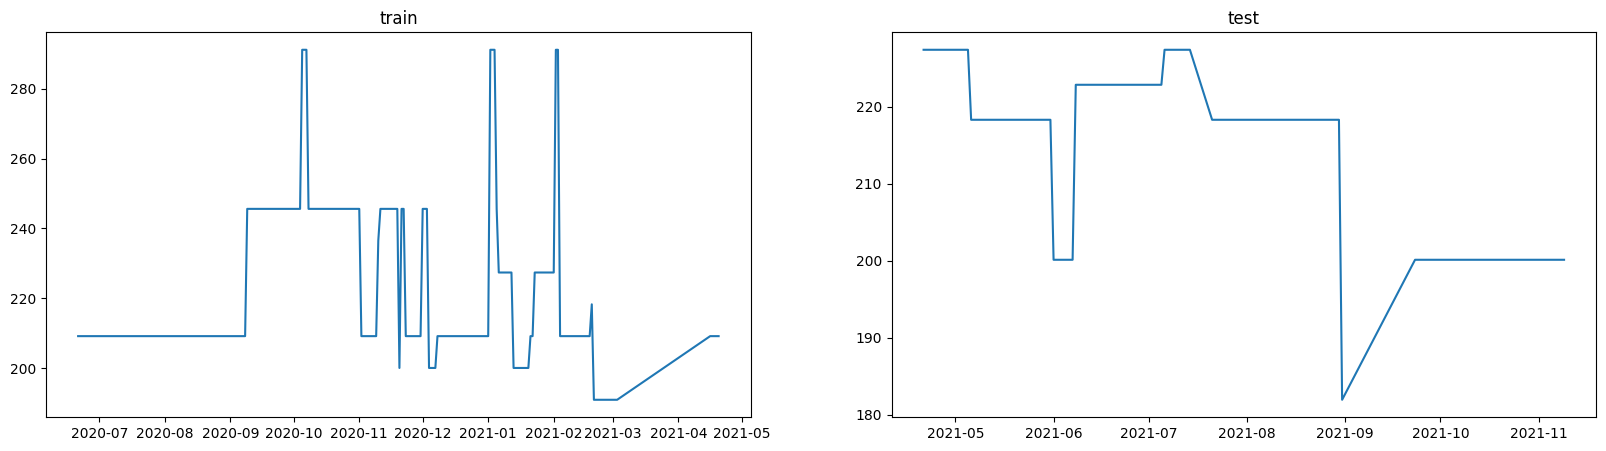

In [12]:
i = 1
plt.figure()
f = plt.figure(figsize=(20,5))
for j in (1,2):
    if j ==1:
        plt.subplot(1, 2, i)
        plt.plot(train["ds"],train["y"])
        plt.title("train")
    else:
        plt.subplot(1, 2, i)
        plt.plot(test["ds"],test["y"])
        plt.title("test")
    i += 1
plt.show()

# HyperParameter Tuning using ParameterGrid

**Prepare the data**

In [13]:
percent_train = 0.6
value = int(len(raw_seq)*percent_train)
train = {"ds":df_wide.index.tolist()[:value],"y":raw_seq[:value]}
test = {"ds":df_wide.index.tolist()[value:],"y":raw_seq[value:]}
train = pd.DataFrame(train)
test = pd.DataFrame(test)

print(train.shape)
print(test.shape)

(304, 2)
(203, 2)


In [14]:
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print('Number of models to be tested: %d' % len(all_params))
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(train)  
    # Cross-validation
    df_cv = cross_validation(m, initial='100 days', period='1 days', horizon = '20 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=percent_train)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

00:14:35 - cmdstanpy - INFO - Chain [1] start processing


Number of models to be tested: 32


00:14:35 - cmdstanpy - INFO - Chain [1] done processing
00:15:05 - cmdstanpy - INFO - Chain [1] start processing
00:15:05 - cmdstanpy - INFO - Chain [1] done processing
00:15:34 - cmdstanpy - INFO - Chain [1] start processing
00:15:34 - cmdstanpy - INFO - Chain [1] done processing
00:16:04 - cmdstanpy - INFO - Chain [1] start processing
00:16:04 - cmdstanpy - INFO - Chain [1] done processing
00:16:33 - cmdstanpy - INFO - Chain [1] start processing
00:16:33 - cmdstanpy - INFO - Chain [1] done processing
00:17:03 - cmdstanpy - INFO - Chain [1] start processing
00:17:03 - cmdstanpy - INFO - Chain [1] done processing
00:17:33 - cmdstanpy - INFO - Chain [1] start processing
00:17:33 - cmdstanpy - INFO - Chain [1] done processing
00:18:02 - cmdstanpy - INFO - Chain [1] start processing
00:18:02 - cmdstanpy - INFO - Chain [1] done processing
00:18:32 - cmdstanpy - INFO - Chain [1] start processing
00:18:32 - cmdstanpy - INFO - Chain [1] done processing
00:18:53 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [15]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])
# Fit the model on the training dataset
auto_model.fit(train)
# Cross validation
auto_model_cv = cross_validation(m, initial='100 days', period='1 days', horizon = '20 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=percent_train)
print('MAPE:',auto_model_p['mape'].values[0])
print('MAE:',auto_model_p['mae'].values[0])
print('MSE:',auto_model_p['mse'].values[0])

00:27:18 - cmdstanpy - INFO - Chain [1] start processing
00:27:18 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.07805860427437034
MAE: 17.402984351434775
MSE: 542.1186783774923


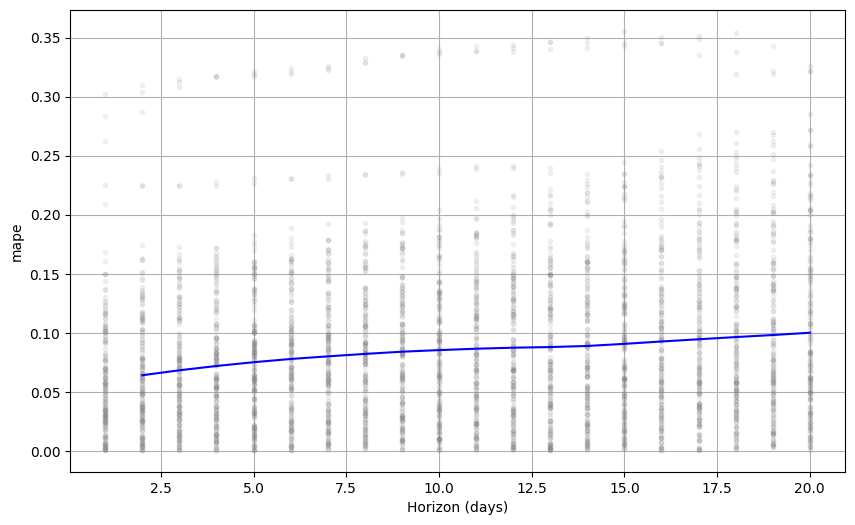

In [16]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(auto_model_cv,metric= 'mape')

In [17]:
# The interval (parameter freq) is set to ‘D’ (day) by default
future=auto_model.make_future_dataframe(periods=len(test), freq='D')
forecast=auto_model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-21,204.391320,185.063581,222.967904,204.391320,204.391320,0.268737,0.268737,0.268737,0.268737,0.268737,0.268737,0.0,0.0,0.0,204.660057
1,2020-06-22,204.548001,185.820815,225.087746,204.548001,204.548001,-0.277292,-0.277292,-0.277292,-0.277292,-0.277292,-0.277292,0.0,0.0,0.0,204.270709
2,2020-06-23,204.704682,185.970407,225.585700,204.704682,204.704682,1.874886,1.874886,1.874886,1.874886,1.874886,1.874886,0.0,0.0,0.0,206.579568
3,2020-06-24,204.861362,187.766965,226.395074,204.861362,204.861362,1.729310,1.729310,1.729310,1.729310,1.729310,1.729310,0.0,0.0,0.0,206.590672
4,2020-06-25,205.018043,184.095652,223.611102,205.018043,205.018043,-0.932655,-0.932655,-0.932655,-0.932655,-0.932655,-0.932655,0.0,0.0,0.0,204.085388


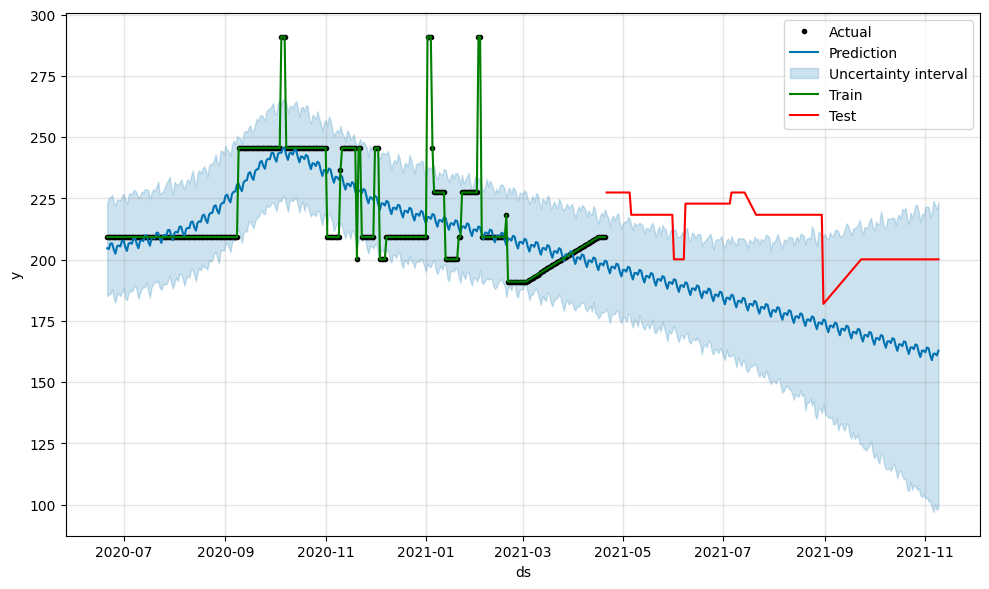

In [18]:
fig = m.plot(forecast)
plt.plot(train['ds'],train['y'], color = 'green')
plt.plot(test['ds'],test['y'], color = 'red')
plt.legend(['Actual', 'Prediction', 'Uncertainty interval', 'Train', 'Test'])
plt.show()

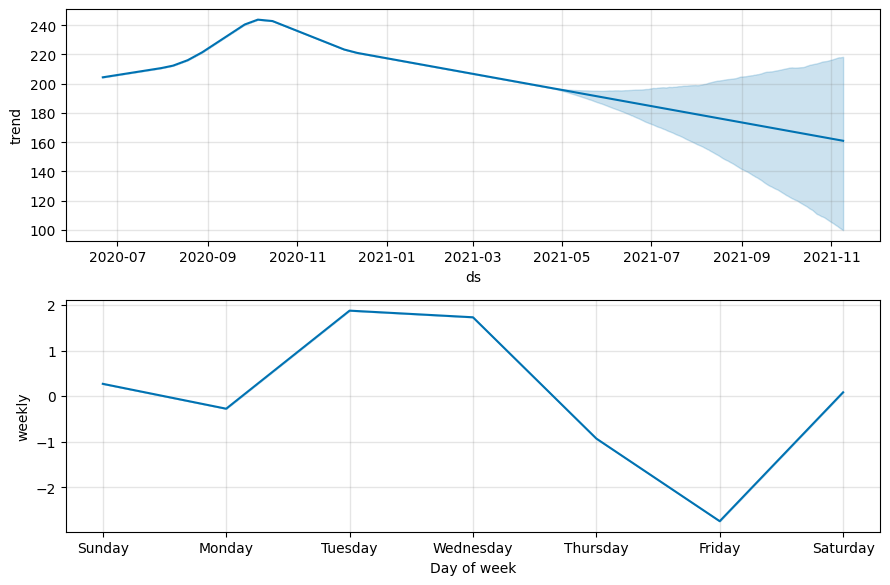

In [19]:
# Plot the components of the model
fig = auto_model.plot_components(forecast)

In [20]:
X_tst_final= auto_model.predict(test)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
196,2021-11-03,163.785527,100.641142,216.640201
197,2021-11-04,160.942568,100.949824,214.907017
198,2021-11-05,158.948391,99.654271,215.112086
199,2021-11-06,161.596085,102.325512,218.024897
200,2021-11-07,161.600977,101.705109,217.508874
201,2021-11-08,160.873954,102.762052,219.191838
202,2021-11-09,162.845138,99.536378,219.778680


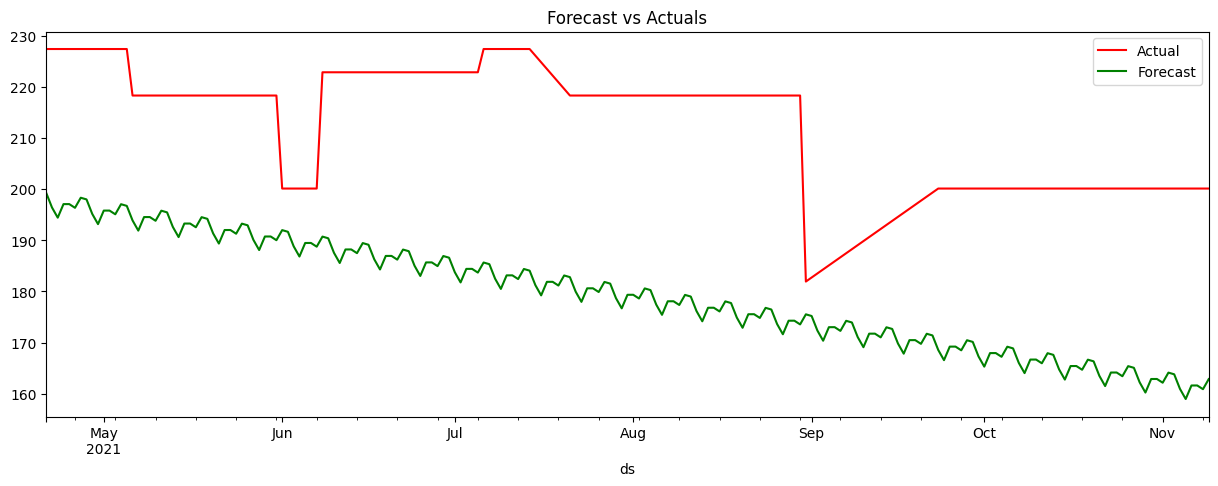

In [21]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

# Trend Change Points
Another interesting functionality of Prophet is add_changepoints_to_plot. As we discussed in the earlier sections, there are a couple of points where the growth rate changes. Prophet can find those points automatically and plot them!

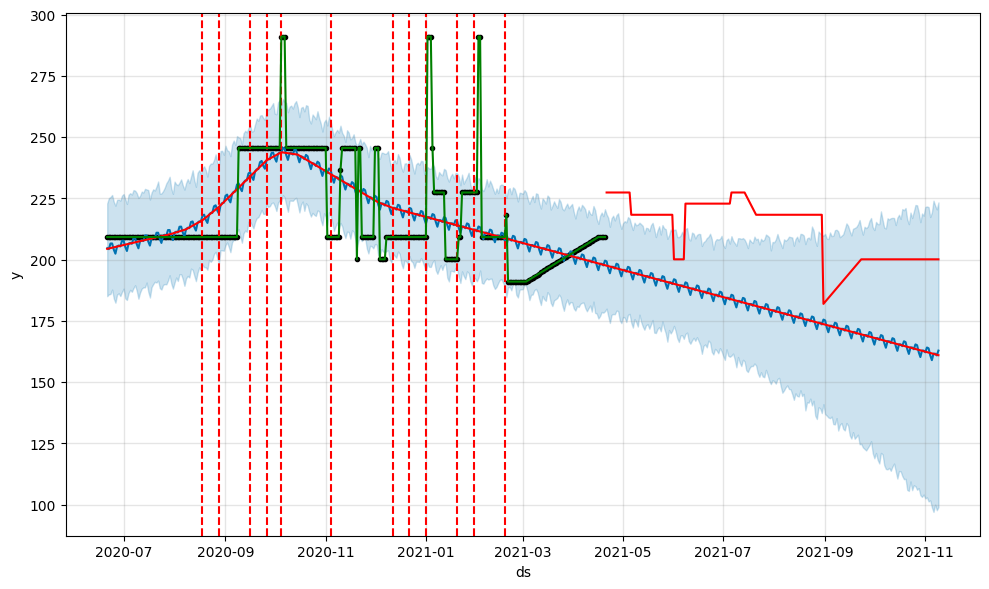

In [22]:
from prophet.plot import add_changepoints_to_plot

# plot change points
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.plot(train['ds'],train['y'], color = 'green')
plt.plot(test['ds'],test['y'], color = 'red')